In [1]:
import time
from datetime import datetime
sc = SparkContext.getOrCreate()
from pyspark.sql.functions import desc
#traces
import pandas as pd
import numpy as np
import re
import sys
import math
#for ordered dict for traces implementation
from collections import OrderedDict
#from pyspark.sql.types import VectorUDT
from pyspark.sql.types import FloatType
from pyspark.sql.types import StringType

from pyspark.sql.functions import udf

from datetime import datetime
from datetime import timedelta
#import sources.endomondolib as endo
#import sources.pysparkconvenience as ps
from numpy import array
from math import sqrt
from pyspark.sql.types import DoubleType
#for timedelta manipulation
from math import fabs

from pyspark.sql import Row

#kmeans
#from pyspark.mllib.clustering import KMeans, KMeansModel
#from pyspark.mllib.linalg import Vectors
#from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

from  pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors, VectorUDT


from pyspark.sql.functions import *
#from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.clustering import BisectingKMeans
from pyspark.sql import DataFrameReader
from pyspark.sql import DataFrame
from pyspark.sql.functions import count
from pyspark.sql.window import Window
from pyspark.sql import SQLContext
from IPython.display import display, HTML
from pyspark.sql.functions import col
#from pyspark.mllib.linalg import Vectors
from pyspark.sql import HiveContext
from pyspark.ml.feature import VectorAssembler

# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.mpl_style = 'default'

from pyspark.ml.feature import StandardScaler

from pyspark import SparkContext
#sc =SparkContext()


pyspark_submit_args = os.environ.get("PYSPARK_SUBMIT_ARGS", "")
if not "pyspark-shell" in pyspark_submit_args: pyspark_submit_args += " pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

#%load_ext autotime
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

#del min
#del max

data_users='/Users/momori/dse/maomori/thesis/git/fitness_capstone/data/run_with_hr_users.csv'

sqlContext = HiveContext(sc)



In [2]:
%load_ext autotime
from functools import reduce
from pyspark.sql import DataFrame

def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [3]:
def df_from_csv(csv_file):
    text = sc.textFile(csv_file)\
        .map(lambda line: line.split(","))
    #didn't work with take(1). believe returns 
    #different object then first()
    schema = text.first()
    data = text.filter(lambda x: x != schema)
    df = sqlContext.createDataFrame(data, schema)
    return df

def fix_df(df):
    return df.rdd.toDF(df.schema.names)


def change_column_names(df, old_names, new_names):
    pass
    return df;

time: 6.92 ms


In [4]:
#df_from_csv('f_cluster.csv')

time: 2.57 ms


In [5]:
#minMaxScaler wrapper since originalMin/Max is only implemented in 2.0
class scaler_wrapper():
    mmModel = ''
    originalMin = ''
    originalMax = ''   
    uf = udf(lambda x: 'new_value', StringType())
    s_udf = udf(lambda value: value*self.mmModel.getWithStd() + self.mmModel.getWithMean())
    scale = 1
    
    
    def __init__(self, inputCol, outputCol, s_min = 0, s_max = 0):
        #self.mmModel = MinMaxScaler(inputCol=inputCol, outputCol=outputCol)
        self.mmModel = StandardScaler(inputCol=inputCol, outputCol=outputCol)
        self.mmModel.setWithMean(True)
        #self.mmModel.setMin(s_min)
        #self.mmModel.setMax(s_max)
        self.in_column = inputCol
        self.scale = s_max;
        
    def get_input_col_name(self):
        return self.mmModel.getInputCol()

    def getMax(self):
        return self.mmModel.getMax()
    
    def getMin(self):
        return self.mmModel.getMin()
    
    def describe(self):
        print 'describe'
    
    def fit(self, df):
        col = self.mmModel.getInputCol()
        #self.originalMin = df.select(col).rdd.flatMap(lambda x: x[0]).min()
        #self.originalMax = df.select(col).rdd.flatMap(lambda x: x[0]).max()
        return self.mmModel.fit(df)
    
    #denormalize the value
    def denormalize(self, value):
        #udf = UserDefinedFunction(lambda x: 'new_value', StringType())
        print 'deno'
        return 5
        #return value*self.mmModel.getWithStd() + self.mmModel.getWithMean()
        #return 0
        #v = (value-self.getMin())*\
        #    (self.originalMax - self.originalMin)*\
        #    (self.getMax()-self.getMin()) + self.originalMin
        #if v or v == 0:
        #    return v
        #else:
        #    return -999
        
    def denormalize_df(self, df):
        col = self.mmModel.getInputCol()
        print col
        
        
    def normalize(self, value):
        pass

time: 93.3 ms


In [6]:
sc

time: 3.13 ms


In [45]:
#calculate sse
def compute_sse(a,b):
    total = 0
    if len(a) != len(b):
        print 'bad input'
        return 99999
    else:
        for i in range(len(a)):
            total += math.pow(float(a[i])-float(b[i]),2)
    return math.sqrt(total)

def change_type_col_double(df, col):
    df = df.withColumn(col, df[col].cast("double"))
    return df.na.fill(0)

#change column type
def change_type_cols_double(df, list_cols):
    for col_name in list_cols:
        df = df.withColumn(col_name, df[col_name].cast("float"))
    return df.na.fill(0)

def normalize_vectorize_df(df, list_cols, scale_dict={}):
    n_df = vectorize_columns(df, list_cols)
    n_df, scalerModels = normalize_df(n_df, list_cols, scale_dict)
    return n_df, scalerModels
#vectorize the column
#keeps the original name
def vectorize_columns(df, list_cols, debug=False):
    a = datetime.now()
    tmp_col_name = 'temp'
    for col_name in list_cols:
        vectorize = udf(lambda vs: Vectors.dense(vs), VectorUDT())
        df = df.withColumn(tmp_col_name, vectorize(df[col_name])).drop(col_name)\
            .withColumnRenamed(tmp_col_name, col_name)
    b = datetime.now()
    print 'vectorize done in:', b-a
    return df

##scaler wrapper usage
#generate normalized dataframe
#keep the original column names
#returns:
#   (df, {col_name:scalerModel, col_name:scalerModel,....})
def normalize_df_old(df, list_cols, scale_dict = {}, debug=False):
    tmp_col_name = 'temp'
    r_dict = {}
    index = 0
    for col_name in list_cols:
        if debug:
            print '------- normalize ', col_name,'-------'
        a = datetime.now()
        scale_value = 1
        if col_name in scale_dict:
            scale_value = scale_dict[col_name]
            print scale_value
        #scaler is the wrapper instance
        scaler = scaler_wrapper(inputCol=col_name, outputCol=tmp_col_name, s_max = scale_value)
        scalerModel = scaler.fit(df)
        b = datetime.now()
        if debug:
            print b-a
        df = scalerModel.transform(df).drop(col_name)\
            .withColumnRenamed(tmp_col_name, col_name)
        #r_dict[col_name] = scaler
        r_dict[index] = scaler
        c =datetime.now()
        if debug:
            print c-b
        index+=1
    return df, r_dict


#   (df, {col_name:scalerModel, col_name:scalerModel,....})
def normalize_df(df, list_cols, scale_dict = {}, debug=False):
    tmp_col_name = 'temp'
    #print 'masa1', df.select(['geo_distance','diff_altitude','workoutid']).describe().show(10,False)

    r_dict = {}
    index = 0
    for col_name in list_cols:
        if debug:
            print '------- normalize ', col_name,'-------'
        a = datetime.now()
        scale_value = 1
        if col_name in scale_dict:
            scale_value = scale_dict[col_name]
            print scale_value
        #scaler is the wrapper instance
        scaler = scaler_wrapper(inputCol=col_name, outputCol=tmp_col_name, s_max = scale_value)
        scalerModel = scaler.fit(df)
        b = datetime.now()
        if debug:
            print b-a
        df = scalerModel.transform(df).drop(col_name)\
            .withColumnRenamed(tmp_col_name, col_name)
        #take out values based on std
        #print df.show()
        df = df.withColumn(col_name, unvector(df[col_name]))
        df = df.filter(df[col_name]<3)

        
        r_dict[col_name] = scalerModel
        c =datetime.now()
        if debug:
            print c-b
        index+=1
    return df, r_dict


# MinMaxScaler doesn't have originalMin(only supported in 2.0). made one above cell with wrapper class
# #generate normalized dataframe
# #keep the original column names
# #returns:
# #   (df, {col_name:scalerModel, col_name:scalerModel,....})
# def normalize_df(df, list_cols):
#     tmp_col_name = 'temp'
#     r_dict = {}
#     for col_name in list_cols:
#         scaler = MinMaxScaler(inputCol=col_name, outputCol=tmp_col_name)
#         scalerModel = scaler.fit(df)
#         df = scalerModel.transform(df).drop(col_name)\
#             .withColumnRenamed(tmp_col_name, col_name)
#         r_dict[col_name] = [scaler, scalerModel]
#     return df, r_dict

#input: (MLLIB KMEANS)
#   cols_to_cluster: list of column names to cluster
# def cluster_summary_df(df, cols_to_cluster, num_clusters = 2):
#     vecAssembler = VectorAssembler(inputCols=cols_to_cluster,\
#         outputCol='features')
#     df_to_cluster = vecAssembler.transform(df.na.fill(0))
#     df_to_cluster = df_to_cluster.select('features')
#     df_to_cluster = df_to_cluster.rdd\
#         .map(lambda row : Vectors.dense([item for item in row]))
#     clusters = KMeans.train(df_to_cluster, num_clusters,\
#                            maxIterations = 10,\
#                         initializationMode="random")
    
#     return clusters


# #create feature column from list of cols
# def create_feature_column(df, cols_to_cluster):
#     #make dup columns of the ones that will be vectorized
#     normalized_names = [i+'_n' for i in cols_to_cluster]
    
#     norm_and_woutid = [i+'_n' for i in cols_to_cluster]
#     norm_and_woutid.append('workoutid')

#     normalized_df = df
    
#     for c in range(len(cols_to_cluster)):
#         normalized_df = normalized_df.withColumnRenamed(\
#                         cols_to_cluster[c], normalized_names[c])
#     normalized_df = normalized_df.select(norm_and_woutid)

    
#     df = df.join(normalized_df, (df['workoutid']==normalized_df['workoutid']),\
#                 'inner').drop(normalized_df['workoutid'])
#     #df = df.crossJoin(normalized_df)
#     vecAssembler = VectorAssembler(inputCols=normalized_names,\
#         outputCol='features')

#     df_to_cluster = vecAssembler.transform(df.na.fill(0))

#     #normed_df = df_to_cluster.select(normalized_names)
#     return df_to_cluster   
    
def create_feature_column(df, cols_to_cluster):
    vecAssembler = VectorAssembler(inputCols=cols_to_cluster,\
        outputCol='features')

    df_to_cluster = vecAssembler.transform(df.na.fill(0))
    
    #normed_df = df_to_cluster.select(normalized_names)
    return df_to_cluster   
    
    
    
#ML KMEANS
#returns KMeanModel, df_to_cluster
def cluster_summary_df(df, cols_to_cluster, num_clusters = 2, init_var=True, bisectingKMean = True,\
                      debug = False):
   

#     #make dup columns of the ones that will be vectorized
#     normalized_names = [i+'_n' for i in cols_to_cluster]
    
#     norm_and_woutid = [i+'_n' for i in cols_to_cluster]
#     norm_and_woutid.append('workoutid')
#     #make copy
#     a = datetime.now()
#     normalized_df = df
    
#     b = datetime.now()
#     print b-a , 'df copy'
    
#     for c in range(len(cols_to_cluster)):
#         normalized_df = normalized_df.withColumnRenamed(\
#                         cols_to_cluster[c], normalized_names[c])
#     normalized_df = normalized_df.select(norm_and_woutid)

    
#     df = df.join(normalized_df, (df['workoutid']==normalized_df['workoutid']),\
#                 'inner').drop(normalized_df['workoutid'])
#     #df = df.crossJoin(normalized_df)
#     vecAssembler = VectorAssembler(inputCols=normalized_names,\
#         outputCol='features')

#     df_to_cluster = vecAssembler.transform(df.na.fill(0))

#     normed_df = df_to_cluster.select(normalized_names)
    
    
#    df_to_cluster = df_to_cluster.select(['workoutid','features'])
    #df_to_cluster = df_to_cluster.rdd\
     #   .map(lambda row : Vectors.dense([item for item in row]))
    #print df.count(), 'masa3'
    df_to_cluster = create_feature_column(df, cols_to_cluster)
    #print df_to_cluster.count(), 'masa4'
    #print 'clustering df on', df_to_cluster.select(cols_to_cluster + ['features']).describe().show()
        
    if not bisectingKMean:
        if not init_var:
            kmeans = KMeans(k=num_clusters, seed=1, initMode="random",\
                           featuresCol=cols_to_cluster)
        else:
            
            kmeans = BisectingKMeans().setK(num_clusters)#.setMinDivisibleClusterSize(10)

    else:
        #kmeans = KMeans(k=num_clusters, initMode="k-means||")
        kmeans = KMeans(k=num_clusters)

    #print df_to_cluster.show()
    df_to_cluster = df_to_cluster.repartition(30)
    
    a = datetime.now()
    model = kmeans.fit(df_to_cluster)
    
    b = datetime.now()
    if debug:
        print 'clustering in ', b-a
    return model, df_to_cluster



# def cluster_summary_df(df, cols_to_cluster, num_clusters = 2, init_var=False):
#     #make dup columns of the ones that will be vectorized
#     normalized_names = [i+'_n' for i in cols_to_cluster]
    
#     norm_and_woutid = [i+'_n' for i in cols_to_cluster]
#     norm_and_woutid.append('workoutid')
#     #make copy
#     a = datetime.now()
#     normalized_df = df.copy()
    
#     b = datetime.now()
#     print b-a , 'df copy'
    
#     for c in range(len(cols_to_cluster)):
#         normalized_df = normalized_df.withColumnRenamed(\
#                         cols_to_cluster[c], normalized_names[c])
#     normalized_df = normalized_df.select(norm_and_woutid)

    
#     df = df.join(normalized_df, (df['workoutid']==normalized_df['workoutid']),\
#                 'inner').drop(normalized_df['workoutid'])
#     #df = df.crossJoin(normalized_df)
#     vecAssembler = VectorAssembler(inputCols=normalized_names,\
#         outputCol='features')

#     df_to_cluster = vecAssembler.transform(df.na.fill(0))

#     normed_df = df_to_cluster.select(normalized_names)
    
    
# #    df_to_cluster = df_to_cluster.select(['workoutid','features'])
#     #df_to_cluster = df_to_cluster.rdd\
#      #   .map(lambda row : Vectors.dense([item for item in row]))
        
#     print 'clustering times'
#     a = datetime.now()
#     if not init_var:
#         kmeans = KMeans(k=num_clusters, seed=1, initMode="random",\
#                        featuresCol=cols_to_cluster)
#     else:
#         kmeans = KMeans(k=num_clusters, seed=1, initMode="k-means||")
#     b = datetime.now()
#     print b - a
    
#     model = kmeans.fit(df_to_cluster)
    
#     c = datetime.now()
#     print c - b
#     return model, df_to_cluster

def scale_df(df, scale_dict):
    for k,v in scale_dict.iteritems():
        col = k
        scale = v
        df = df.withColumn(col, df[col] * scale)
    return df
    


#returns clusters. show cluster centerse by clusters.clusterCenters.
#output:
#   [0]: KMeanModel
#   [1]: DF that will be denormalized
#   [2]: ScalerModels
#   [3]: error
#   [4]: DF with features
def cluster_df(df, cols_to_normalize, num_clusters = 2, return_sse = True, cols_to_cluster = [], init_var=True,\
              scale_dict = {}, bisectingKMean = True, debug = False):
    print 'cluster start'
    if not cols_to_cluster:
        cols_to_cluster = cols_to_normalize
    df = change_type_cols_double(df, cols_to_normalize)
    #print 'masa2', df.select(['geo_distance','diff_altitude','workoutid']).describe().show(10,False)
    df = vectorize_columns(df, cols_to_normalize, debug)
    #print 'masa3', df.select(['geo_distance','diff_altitude','workoutid']).describe().show(10,False)
    df, scalerModels = normalize_df(df, cols_to_cluster, scale_dict, debug)
    #print 'masa4', df.select(['geo_distance','diff_altitude','workoutid']).describe().show(10,False)
    
    unscaled_df = df
    
    #print 'before scaling*****', df.select(cols_to_cluster).describe().show()

    
    df = scale_df(df, scale_dict)
    
    
    
    ##*******************
    #df is object to cluster. if creating kmean models off of subset of cluster, 
    #make subset here
    
    ##*******************
    #print 'after scaling*****', df.select(cols_to_cluster).describe().show()
    
    r_obj = cluster_summary_df(df, cols_to_cluster, num_clusters, init_var, bisectingKMean, \
                              debug)
    sse = 'none'
    if return_sse:
        #calculate SSE for this kmean model
        kmodel = r_obj[0]
        centers = kmodel.clusterCenters()
        df_to_cluster = r_obj[1]
        centers = kmodel.clusterCenters()
        prediction_df = kmodel.transform(df_to_cluster)
        #print centers
        #print df_to_cluster.select(cols_to_cluster).describe().show()
    
        #set up rdd
        #rdd = prediction_df.rdd.map(lambda (a,b):\
        #                           (a, centers[b]))
        rdd = prediction_df.select(['features','prediction']).\
            rdd.map(lambda(a,b): (a, ret_cluster_center(centers, b)))
        
        
        sse = rdd.map(lambda (a,b): compute_sse(a,b)).sum()
    return r_obj[0], df, scalerModels, sse, r_obj[1], unscaled_df
    #return r_obj[0], r_obj[1], scalerModels, sse

def denormalize_centers(list_centers, scaler_models):
    new_centers = []
    for center in list_centers:
        n_center = []
        for c in range(len(center)):
            n_center.append(scaler_models[c].denormalize(center[c]))
        new_centers.append(n_center)
    return new_centers


#minmax
# def denormalize_cluster(cluster_centers, list_scaler_models):
#     r_centers = []
#     for center in cluster_centers:
#         r_center = []
#         for index in range(len(center)):
#             s_model = list_scaler_models[index]
#             r_center.append(s_model.denormalize(center[index]))
#         r_centers.append(r_center)
#     return r_centers


def denormalize_cluster(cluster_centers, list_scaler_models, columns):
    r_centers = []
    length = len(columns)
    for center in cluster_centers:
        r_center = []
        print center
        denormed_center = [0]*length
        
        #for each scaler models, get index in columns and denorm
        for k,v in list_scaler_models.iteritems():
            col_name = k
            model = v
            index = columns.index(col_name)
            #print index, 'masa2'
            denormed_center[index] = center[index]*model.std+model.mean
        r_centers.append(denormed_center)
        
#         for index in range(len(center)):
#             s_model = list_scaler_models[index]
#             #model = s_model.mmModel
#             denormed_val = center[index]*s_model.std+s_model.mean
#             r_center.append(denormed_val)
#         r_centers.append(r_center)
    return r_centers

def get_distribution_of_workouts(transformed_df):
    #count of predictions
    return transformed_df.groupBy('prediction').count().orderBy('prediction')

#transform (add prediction column) to the dataframe based on the kmeamodel input
def transform_df_with_kmeamodel(kmeanModel, df, cols_to_cluster, scale_dict={}):
    #need to vectorize and normalize the df
    df_to_transform, scalerModels = normalize_vectorize_df(big_sumstats, cols_to_cluster, scale_dict)
    df_to_transform = create_feature_column(df_to_transform, cols_to_cluster)
    return kmeanModel.transform(df_to_transform), scalerModels



#
def vectorizeData(data):
    return data.rdd.map(lambda r: [r[0], r[1], r[2], Vectors.dense(r[3:6]), r[7]]).toDF([\
            'prediction', 'userid', 'workoutid', 'label', 'max_elapsed_time'])

# total_df= fix_df(sumstats.join(prediction_df.select('workoutid','prediction'), \
#                                sumstats['workoutid']==prediction_df['workoutid'],'inner').\
#                             drop(prediction_df['workoutid']))

def denorm_df_with_standarscaler(dict_scalerModels, df):
    for k,v in dict_scalerModels.iteritems():
        #print '--denorm ', k, '--'
        col_name = k
        scaler = v
        mean = float(scaler.mean[0])
        std = float(scaler.std[0])
        denorm_udf = udf(lambda value: value*std + mean, FloatType())
        df = df.withColumn(col_name, denorm_udf(df[col_name]))
    return df
    
#     mean = float(scalerModel.mean[0])
#     std = float(scalerModel.std[0])
#     denorm_udf = udf(lambda value: value*std + mean, FloatType())
#     return df.withColumn()
    
    
    
    
#     def test(scaler, df):
#     dist_scaler = scaler
#     print df.describe().show(10,False)
#     #nd = df.withColumn('geo_distance', dist_scaler.s_udf(df['geo_distance']))
#     mean = float(dist_scaler.mean[0])
#     std = float(dist_scaler.std[0])
#     print mean,std
#     denorm_udf = udf(lambda value: value*std + mean, FloatType())
#     #denorm_udf = udf(lambda value: value*std, FloatType())

#     #denorm_udf = udf(lambda x: 'new_value', StringType())

#     r_df = df.withColumn('geo_distance', denorm_udf(df['geo_distance']))

def ret_cluster_center(centers, index):
    return centers[index]


def filter_data(df):
    df = df.filter(df['elapsed_time']<21600).filter(df['elapsed_time'] > 499)
    df = df.filter(df['geo_distance'] > 0)
    #df = df.filter(df['diff_altitude']<5300)
    df = df.withColumn('diff_altitude', when(df['diff_altitude']<500, df['diff_altitude'])\
                                            .otherwise(500))
    #df = df.withColumn('geo_distance', when(df['geo_distance']<0.7, df['geo_distance'])\
    #                                        .otherwise(0.7))
    df = df.filter(df['geo_distance'] <0.5)
    df = df.filter(df['speed_avg']<20)

    df = df.filter(df['heart_rate_avg'] < 200)
    #df = df.filter(df['speed_avg'] > 0)

    print df.count()
    return df


time: 1.11 s


In [8]:
#magic
unvector = udf(lambda value: value[0].item(), FloatType())

time: 7.23 ms


In [9]:
# from pyspark.ml.feature import PCA
# ignore = ['gender', 'series_time_delta', 'timezone']

# assembler = VectorAssembler(
#     inputCols=[x for x in sumstats.columns if x not in ignore],
#     outputCol='features')

# features_df = assembler.transform(sumstats)

# features_df.schema

# pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
# model = pca.fit(features_df)

# result = model.transform(features_df).select("pcaFeatures")
# #result.show(truncate=False)

time: 2.27 ms


In [10]:
# print result.limit(2).collect()[0].pcaFeatures
# print '\n'
# print model.explainedVariance

time: 908 µs


In [11]:
# df\
# .withColumn('Id_New',when(df.Rank <= 5,df.Id).otherwise('other'))\

time: 628 µs


In [47]:
from pyspark.sql import DataFrameReader

#url = 'postgresql://34.199.246.37:5432/endomondo_sample'
url = 'postgresql://34.199.246.37:5432/endomondo'

properties = {'user':'endomondo', 'password': 'End0m0ndo'}

df_runs = DataFrameReader(sqlContext).jdbc(url='jdbc:%s' % url, table='run', properties=properties)

df_users = DataFrameReader(sqlContext).jdbc(url='jdbc:%s' % url, table='run_by_workout', properties=properties)

df_users

DataFrame[gender: string, workoutid: int, userid: int, start_time: int, start_altitude: decimal(20,10), start_latitude: decimal(20,10), start_longitude: decimal(20,10), series_length: int, series_time_delta: array<int>, series_time_delta_average: decimal(20,10), timezone: string, id: int, altitude_max: decimal(20,10), altitude_min: decimal(20,10), calories: decimal(20,10), distance: decimal(20,10), duration: decimal(20,10), heart_rate_avg: decimal(20,10), heart_rate_max: decimal(20,10), hydration: decimal(20,10), speed_avg: decimal(20,10), speed_max: decimal(20,10), humidity: int, temperature: int, wind_speed: int, elapsed_time: int, geo_distance: decimal(15,10), altitude_max2: decimal(20,10), altitude_min2: decimal(20,10), time_since_last_workout: int, speed_avg2: decimal(20,10), speed_max2: decimal(20,10)]

time: 56.3 ms


['altitude',
 'heart_rate',
 'latitude',
 'longitude',
 'speed',
 'workoutid',
 'time',
 'altitude_first',
 'altitude_second',
 'speed_first',
 'elapsed_distance',
 'elapsed_time',
 'heart_rate_ma_25',
 'speed_ma_50',
 'speed_ma_100',
 'geo_distance',
 'speed_by_geo',
 'altitude2']

time: 4.17 ms


In [13]:
df_users = df_users.sample(False, 0.1)

time: 20.5 ms


In [14]:
df_users.schema.names

['gender',
 'workoutid',
 'userid',
 'start_time',
 'start_altitude',
 'start_latitude',
 'start_longitude',
 'series_length',
 'series_time_delta',
 'series_time_delta_average',
 'timezone',
 'id',
 'altitude_max',
 'altitude_min',
 'calories',
 'distance',
 'duration',
 'heart_rate_avg',
 'heart_rate_max',
 'hydration',
 'speed_avg',
 'speed_max',
 'humidity',
 'temperature',
 'wind_speed',
 'elapsed_time',
 'geo_distance',
 'altitude_max2',
 'altitude_min2',
 'time_since_last_workout',
 'speed_avg2',
 'speed_max2']

time: 5.04 ms


In [72]:
df_runs.repartition(30).select(df_runs.workoutid==197900748).show()

KeyboardInterrupt: 

time: 5min 5s


In [ ]:
df_runs

In [16]:
df_users.count()

34755

time: 2.37 s


In [17]:
#df_users[['altitude_max2','altitude_min2']].describe().show()

time: 480 µs


In [48]:
sub_df = df_runs.limit(1000)
df_users = df_users.withColumn('diff_altitude', \
                    df_users['altitude_max2'] \
                    -df_users['altitude_min2'])
all_cols = ['elapsed_time','diff_altitude'\
            ,'geo_distance','heart_rate_avg','speed_avg']
sumstats = change_type_cols_double(df_users, all_cols)
sumstats = filter_data(sumstats.repartition(30))
print sumstats.count()
#sumstats = df_users.limit(2000).repartition(30)

304630
304630
time: 1.82 s


In [67]:
c = ['workoutid', 'userid','elapsed_time','diff_altitude'\
            ,'geo_distance','heart_rate_avg','speed_avg']
c

['workoutid',
 'userid',
 'elapsed_time',
 'diff_altitude',
 'geo_distance',
 'heart_rate_avg',
 'speed_avg']

time: 2.99 ms


In [70]:
sumstats.select(c).where(sumstats.heart_rate_avg > 0).where(sumstats.speed_avg > 0)\
    .where(sumstats.workoutid==197900748).show(5)

+---------+-------+------------+-------------+------------+--------------+---------+
|workoutid| userid|elapsed_time|diff_altitude|geo_distance|heart_rate_avg|speed_avg|
+---------+-------+------------+-------------+------------+--------------+---------+
|197900748|1912029|      1618.0|    15.294235|  0.05643702|     195.48166|11.247107|
+---------+-------+------------+-------------+------------+--------------+---------+

time: 8.19 s


In [68]:
sumstats.select(c).where(sumstats.heart_rate_avg > 0).where(sumstats.speed_avg > 0).show(5)

+---------+-------+------------+-------------+------------+--------------+---------+
|workoutid| userid|elapsed_time|diff_altitude|geo_distance|heart_rate_avg|speed_avg|
+---------+-------+------------+-------------+------------+--------------+---------+
|197900748|1912029|      1618.0|    15.294235|  0.05643702|     195.48166|11.247107|
|220954943|9345869|      1351.0|    22.245594| 0.046508357|    117.810356|  9.29343|
|246808630|1912029|      2154.0|    23.505724|  0.06895277|     169.36867| 8.857457|
|260961987|4362441|      4489.0|    63.033417|  0.16640514|     142.12593|11.588177|
|273495603| 324779|      3395.0|        169.8|  0.08341786|     150.04448| 8.896097|
+---------+-------+------------+-------------+------------+--------------+---------+
only showing top 5 rows

time: 4.16 s


In [17]:
# ##pca

# interest = ['diff_altitude','elapsed_time','geo_distance','heart_rate_avg','speed_avg']

# assembler = VectorAssembler(
#     inputCols=[x for x in sumstats.columns if x in interest],
#     outputCol='features')

# df_features = assembler.transform(sumstats)
# df_features.schema

time: 1.5 ms


In [18]:

# def estimateCovariance(df):
#     """Compute the covariance matrix for a given dataframe.

#     Note:
#         The multi-dimensional covariance array should be calculated using outer products.  Don't
#         forget to normalize the data by first subtracting the mean.

#     Args:
#         df:  A Spark dataframe with a column named 'features', which (column) consists of DenseVectors.

#     Returns:
#         np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
#             length of the arrays in the input dataframe.
#     """
#     m = df.select(df['features']).rdd.map(lambda x: x[0]).mean()
#     dfZeroMean = df.select(df['features']).rdd.map(lambda x:   x[0]).map(lambda x: x-m)  # subtract the mean

#     return dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()

time: 2.21 ms


In [19]:
#rd = estimateCovariance(df_features)

time: 530 µs


In [20]:
# for i in rd:
#     for j in i:
#         print j,
#     print '\n'
# interest = ['diff_altitude','elapsed_time','geo_distance','heart_rate_avg','speed_avg']


time: 914 µs


In [50]:
time_hist = sumstats.select('elapsed_time')\
    .select('elapsed_time').rdd.flatMap(lambda x: x).histogram(50)
alt_hist = sumstats.select('diff_altitude').rdd.flatMap(lambda x: x).histogram(50)
dist_hist = sumstats.select('geo_distance')\
    .select('geo_distance').rdd.flatMap(lambda x: x).histogram(50)
hr_hist = sumstats.select('heart_rate_avg')\
    .select('heart_rate_avg').rdd.flatMap(lambda x: x).histogram(50)
spd_hist = sumstats.select('speed_avg')\
    .select('speed_avg').rdd.flatMap(lambda x: x).histogram(50)


time: 18.5 s


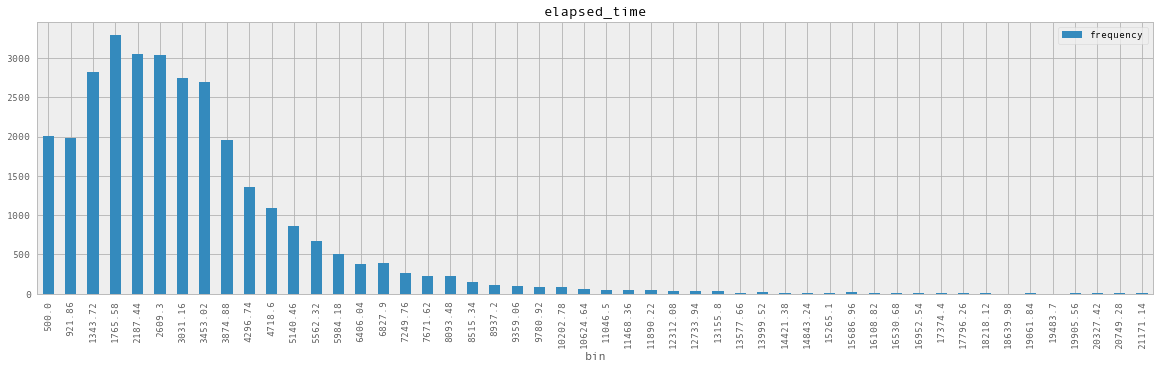

time: 531 ms


In [51]:
pd.DataFrame(zip(list(time_hist)[0],
                     list(time_hist)[1]),columns=['bin','frequency']).set_index('bin')\
                     .plot(kind='bar', title='elapsed_time', figsize=(20,5))

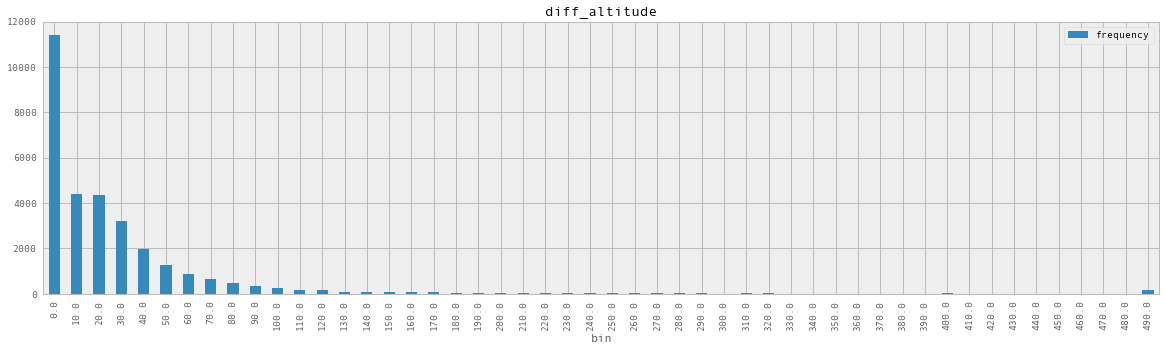

time: 497 ms


In [52]:
pd.DataFrame(zip(list(alt_hist)[0],
                     list(alt_hist)[1]),columns=['bin','frequency']).set_index('bin')\
                     .plot(kind='bar', title='diff_altitude', figsize=(20,5))

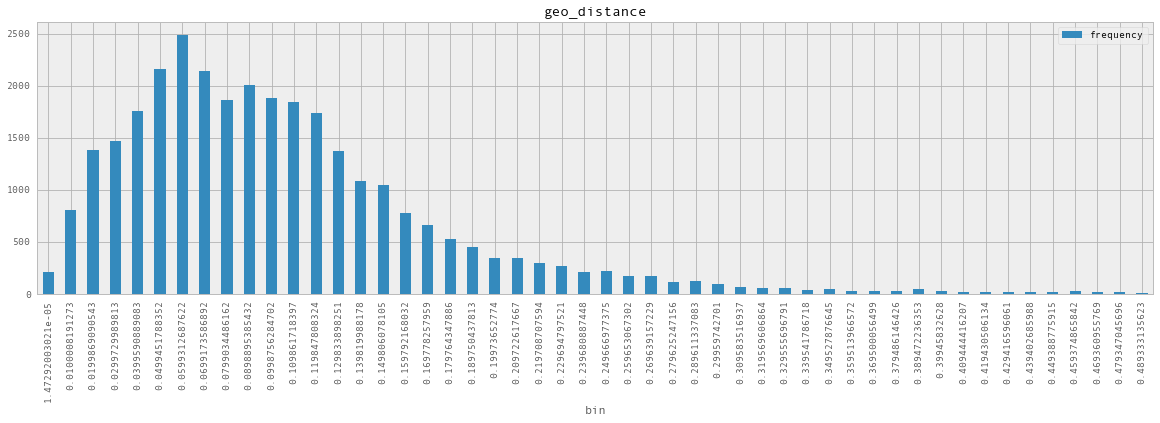

time: 561 ms


In [53]:
pd.DataFrame(zip(list(dist_hist)[0],
                     list(dist_hist)[1]),columns=['bin','frequency']).set_index('bin')\
                     .plot(kind='bar', title='geo_distance', figsize=(20,5))

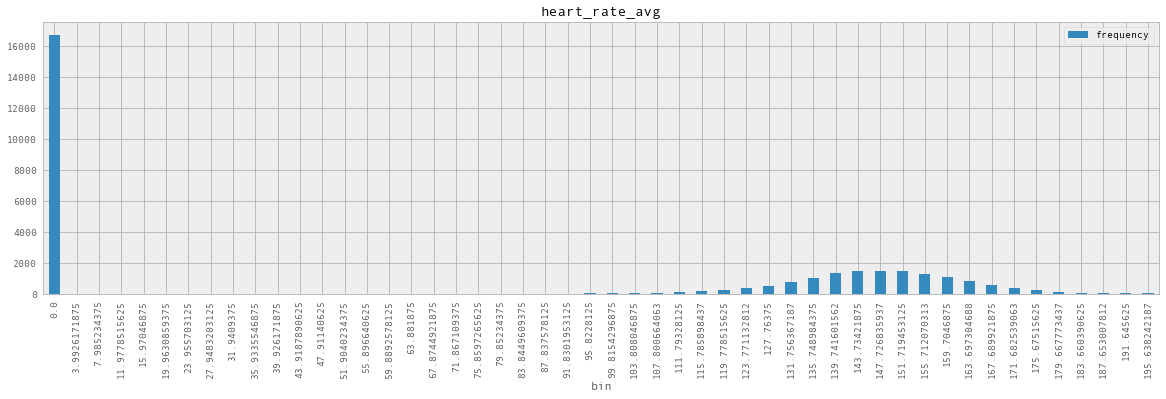

time: 564 ms


In [54]:
pd.DataFrame(zip(list(hr_hist)[0],
                     list(hr_hist)[1]),columns=['bin','frequency']).set_index('bin')\
                     .plot(kind='bar', title='heart_rate_avg', figsize=(20,5))

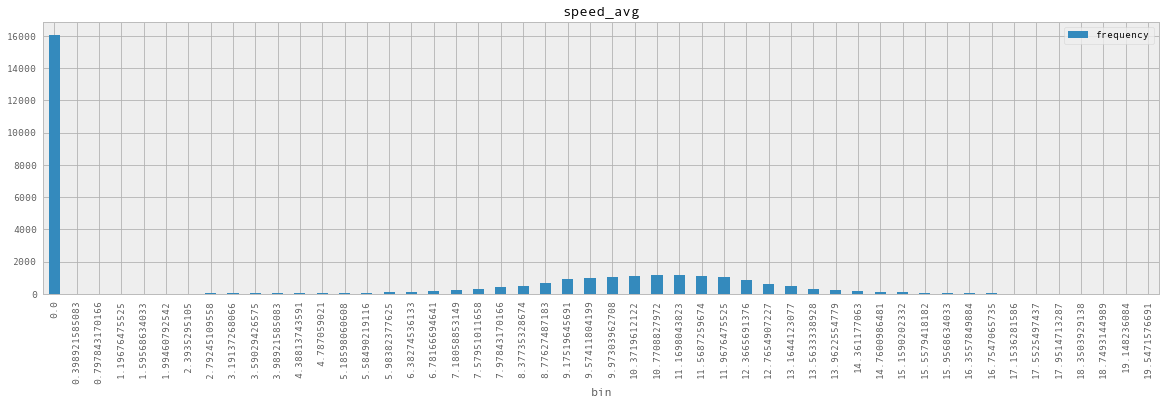

time: 721 ms


In [55]:
pd.DataFrame(zip(list(spd_hist)[0],
                     list(spd_hist)[1]),columns=['bin','frequency']).set_index('bin')\
                     .plot(kind='bar', title='speed_avg', figsize=(20,5))

In [16]:
route_cols = ['diff_altitude', 'geo_distance']
#route_cols = ['diff_altitude']


time: 1.17 ms


In [29]:
sumstats.schema.names

['gender',
 'workoutid',
 'userid',
 'start_time',
 'start_altitude',
 'start_latitude',
 'start_longitude',
 'series_length',
 'series_time_delta',
 'series_time_delta_average',
 'timezone',
 'id',
 'altitude_max',
 'altitude_min',
 'calories',
 'distance',
 'duration',
 'heart_rate_avg',
 'heart_rate_max',
 'hydration',
 'speed_avg',
 'speed_max',
 'humidity',
 'temperature',
 'wind_speed',
 'elapsed_time',
 'geo_distance',
 'altitude_max2',
 'altitude_min2',
 'time_since_last_workout',
 'speed_avg2',
 'speed_max2',
 'diff_altitude']

time: 4.69 ms


In [20]:
sumstats.select(['diff_altitude', 'geo_distance','heart_rate_avg', 'speed_avg', 'elapsed_time'])\
    .toPandas().to_csv('df_for_correlation.csv')

time: 4 s


In [29]:
# errors = []
# for i in [5,7,9,11]:
#     r_obj = cluster_df(sumstats, route_cols, i, init_var=True,\
#                   scale_dict=scale_dict, bisectingKMean=True,\
#                   return_sse = True, debug=True)
#     errors.append(r_obj[3])
    

time: 897 µs


In [18]:
#scale_dict = {'geo_distance':500}
scale_dict = {}

r_obj = cluster_df(sumstats, route_cols, 5, init_var=True,\
                  scale_dict=scale_dict, bisectingKMean=True,\
                  return_sse = True, debug=True)
print 'done'

cluster start
vectorize done in: 0:00:00.093114
------- normalize  diff_altitude -------
0:00:08.046836
0:00:00.104943
------- normalize  geo_distance -------
0:00:08.687288
0:00:00.081391
clustering in  0:01:25.183995
done
time: 1min 58s


In [55]:
scale_dict = {}

for i in range(1):
    r_obj = cluster_df(sumstats, route_cols, 200, init_var=True,\
                  scale_dict=scale_dict, bisectingKMean=False,\
                  return_sse = False, debug=True)  

    route_kmodel = r_obj[0] #trained on scaled dataframe

    route_df = r_obj[4] ##use this to actually denorm the dataframe, has the features
    route_scalerModels = r_obj[2]
    df_to_denorm = r_obj[1] ##this is the scaled dataframe
    unscaled_df = r_obj[5]
    centers = route_kmodel.clusterCenters()
    
    
    print 'cost --------------',  route_kmodel.computeCost(route_df)
    
    print 'error is' + str(sse)
    
    sse = r_obj[3]

    print 'error is' + str(sse)
    
    denormed_clusters = denormalize_cluster(route_kmodel.clusterCenters(),  route_scalerModels, route_cols)
    #save cluster centers for route
    #unvector = udf(lambda value: value[0].item(), FloatType())
    route_viz_cols = route_cols
    for i in range(len(denormed_clusters)):
        for j in range(len(route_viz_cols)):
            denormed_clusters[i][j] = float(denormed_clusters[i][j][0])
    print denormed_clusters
    
    
    
    

cluster start
vectorize done in: 0:00:00.061725
------- normalize  diff_altitude -------
0:00:01.856924
0:00:00.057310
------- normalize  geo_distance -------
0:00:27.732705
0:00:00.059793
clustering in  0:01:34.644497
cost -------------- 2002.32396533
error isnone
error isnone
[-0.54601546 -1.48057949]
[-0.55068988 -1.34541972]
[-0.45195988 -1.3602632 ]
[-0.54783509 -1.25803389]
[-0.5519806  -1.18511062]
[-0.42896189 -1.27996092]
[-0.39843866 -1.20464936]
[-0.54853513 -1.11462803]
[-0.55034615 -1.05040831]
[-0.56220557 -0.95438037]
[-0.48414004 -0.96262269]
[-0.4211225  -1.08987344]
[-0.34433916 -1.10584178]
[-0.39386061 -0.97045382]
[-0.29860005 -0.97753553]
[-0.55644307 -0.85384006]
[-0.55890418 -0.77548071]
[-0.41797362 -0.85087567]
[-0.45865211 -0.73528872]
[-0.33537432 -0.75222062]
[-0.25846354 -0.81780982]
[-0.34631044 -0.63802475]
[-0.22018842 -0.62660997]
[-0.56279061 -0.71536997]
[-0.56002957 -0.67223844]
[-0.56210703 -0.60978243]
[-0.46639976 -0.61988582]
[-0.56037045 -0.529

In [56]:
scale_dict = {}

for i in range(1):
    r_obj = cluster_df(sumstats, route_cols, 200, init_var=True,\
                  scale_dict=scale_dict, bisectingKMean=True,\
                  return_sse = False, debug=True)  

    route_kmodel = r_obj[0] #trained on scaled dataframe

    route_df = r_obj[4] ##use this to actually denorm the dataframe, has the features
    route_scalerModels = r_obj[2]
    df_to_denorm = r_obj[1] ##this is the scaled dataframe
    unscaled_df = r_obj[5]
    centers = route_kmodel.clusterCenters()


    print 'cost --------------',  route_kmodel.computeCost(route_df)
    
    
    denormed_clusters = denormalize_cluster(route_kmodel.clusterCenters(),  route_scalerModels, route_cols)
    #save cluster centers for route
    #unvector = udf(lambda value: value[0].item(), FloatType())
    route_viz_cols = route_cols
    for i in range(len(denormed_clusters)):
        for j in range(len(route_viz_cols)):
            denormed_clusters[i][j] = float(denormed_clusters[i][j][0])
    print denormed_clusters

cluster start
vectorize done in: 0:00:00.054829
------- normalize  diff_altitude -------
0:00:01.841054
0:00:00.057183
------- normalize  geo_distance -------
0:00:27.966320
0:00:00.046551
clustering in  0:01:12.233347
cost -------------- 1606.66192259
[-0.11883402 -1.10730766]
[-0.559727   -0.19897422]
[-0.31772617  1.07123167]
[-0.55649463  0.14261088]
[ 1.83759874  0.17627984]
[ 0.94096304 -0.89114341]
[ 0.50350264  0.22162925]
[-0.01275191 -0.58020454]
[-0.55289434 -1.01213082]
[ 2.22003555  0.01617072]
[-0.55378816  1.34516319]
[-0.27266164 -0.14827218]
[ 0.08597156  2.07655245]
[-0.54325911  2.84216197]
[ 1.1128633  1.8694362]
[ 0.43433228 -0.22620786]
[ 1.10124627  0.76793402]
[-0.55894235 -0.4812053 ]
[ 1.00242024 -0.17606808]
[ 0.69123498 -1.28124598]
[ 1.18587698 -0.47652728]
[-0.3065456   0.17468337]
[ 2.12551143  2.46973789]
[-0.27619554 -1.10948404]
[-0.17714502  0.3153136 ]
[ 0.28696222  1.4466751 ]
[ 0.02939856  0.03332989]
[ 0.49040081 -0.67319344]
[ 0.71615865  0.53862

In [ ]:
sumstats_sam = sumstats.sample(False, 0.1)


In [19]:
route_kmodel = r_obj[0] #trained on scaled dataframe

route_df = r_obj[4] ##use this to actually denorm the dataframe, has the features
route_scalerModels = r_obj[2]
df_to_denorm = r_obj[1] ##this is the scaled dataframe
unscaled_df = r_obj[5]
centers = route_kmodel.clusterCenters()

sse = r_obj[3]
#route_df.count()

time: 6.74 ms


In [32]:
sse

12229.285835948529

time: 2 ms


In [33]:
# print df_to_denorm.select(route_cols).describe().show()
# print route_df.select(route_cols).describe().show()
# print unscaled_df.select(route_cols).describe().show()


time: 701 µs


In [255]:
print df_to_denorm.schema.names
print route_df.schema.names

['gender', 'workoutid', 'userid', 'start_time', 'start_altitude', 'start_latitude', 'start_longitude', 'series_length', 'series_time_delta', 'series_time_delta_average', 'timezone', 'id', 'altitude_max', 'altitude_min', 'calories', 'distance', 'duration', 'heart_rate_avg', 'heart_rate_max', 'hydration', 'speed_avg', 'speed_max', 'humidity', 'temperature', 'wind_speed', 'elapsed_time', 'time_since_last_workout', 'diff_altitude', 'geo_distance']
['gender', 'workoutid', 'userid', 'start_time', 'start_altitude', 'start_latitude', 'start_longitude', 'series_length', 'series_time_delta', 'series_time_delta_average', 'timezone', 'id', 'altitude_max', 'altitude_min', 'calories', 'distance', 'duration', 'heart_rate_avg', 'heart_rate_max', 'hydration', 'speed_avg', 'speed_max', 'humidity', 'temperature', 'wind_speed', 'elapsed_time', 'time_since_last_workout', 'diff_altitude', 'geo_distance', 'features']
time: 3.82 ms


In [256]:
for k,v in route_scalerModels.iteritems():
    print k,v

geo_distance StandardScaler_4f65bc61e2b7d6e5e3e5
diff_altitude StandardScaler_4e11ae001c0d68fd079a
time: 1.41 ms


In [257]:
###check if routes make sense
#route_df.select(route_cols).toPandas().describe()

time: 575 µs


In [20]:
route_prediction_df = route_kmodel.transform(route_df)
#print route_prediction_df.count()
route_prediction_cols = ['route_prediction','route_features']
distinct_clusters = route_prediction_df.select('prediction').distinct().collect()
route_prediction_df = route_prediction_df.withColumnRenamed('prediction', 'route_prediction')
route_prediction_df = route_prediction_df.withColumnRenamed('features', 'route_features')

route_prediction_df = denorm_df_with_standarscaler(route_scalerModels, route_prediction_df)


time: 12.9 s


In [26]:
route_prediction_df.select(route_cols).describe().show(10,False)

+-------+------------------+-------------------+
|summary|diff_altitude     |geo_distance       |
+-------+------------------+-------------------+
|count  |29324             |29324              |
|mean   |25.881679190930146|0.10199525112995474|
|stddev |31.01545638731787 |0.05946394300081676|
|min    |1.1260349E-6      |8.336154E-6        |
|max    |201.59677         |0.3161977          |
+-------+------------------+-------------------+

time: 11.9 s


In [ ]:
route_prediction_df.select(['diff_altitude','geo_distance']).

In [34]:
route_prediction_df.select(['diff_altitude','geo_distance','route_prediction']).groupby('route_prediction')\
.avg().show()

+----------------+------------------+--------------------+---------------------+
|route_prediction|avg(diff_altitude)|   avg(geo_distance)|avg(route_prediction)|
+----------------+------------------+--------------------+---------------------+
|               1| 24.30398074361864| 0.15952563095747355|                  1.0|
|               3| 30.55235880054157| 0.24229117455594826|                  3.0|
|               4| 98.98522567157826| 0.10638206452167355|                  4.0|
|               2| 16.48113372680445| 0.10395872559496612|                  2.0|
|               0|16.127577447330815|0.047774470214660296|                  0.0|
+----------------+------------------+--------------------+---------------------+

time: 13.1 s


In [35]:
route_prediction_df.select(['diff_altitude','geo_distance','route_prediction']).groupby('route_prediction')\
.count().show()

+----------------+-----+
|route_prediction|count|
+----------------+-----+
|               1| 4735|
|               3| 2101|
|               4| 2581|
|               2| 8915|
|               0|10992|
+----------------+-----+

time: 13.6 s


In [19]:
#route_prediction_df.groupBy('route_prediction').count().show()
#route_prediction_df = fix_df(route_prediction_df)

time: 652 µs


In [36]:
route_kmodel.clusterCenters()

[array([-0.03452128,  1.90703461]),
 array([-0.29317571, -0.93364758]),
 array([-0.22140951,  0.5833277 ]),
 array([-0.23296272, -0.23229265]),
 array([ 1.21485895,  0.10069048])]

time: 7.22 ms


In [20]:
denormed_clusters = denormalize_cluster(route_kmodel.clusterCenters(),  route_scalerModels, route_cols)
#save cluster centers for route
#unvector = udf(lambda value: value[0].item(), FloatType())
route_viz_cols = route_cols
for i in range(len(denormed_clusters)):
    for j in range(len(route_viz_cols)):
        denormed_clusters[i][j] = float(denormed_clusters[i][j][0])
print denormed_clusters

[-0.28492909 -0.84064899]
[-0.10301519  0.7480206 ]
[-0.29001081 -0.02719032]
[-0.05638096  1.9202533 ]
[ 1.19099972 -0.02086711]
[[16.200947555564518, 0.04826058749924713], [26.480365890157664, 0.15924813419587366], [15.913794539578674, 0.1050903919181153], [29.11552822863611, 0.24114259012946393], [99.6013325009954, 0.10553214322358877]]
time: 71.2 ms


In [25]:
route_prediction_df.show()

Py4JJavaError: An error occurred while calling o300.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 92.0 failed 1 times, most recent failure: Lost task 0.0 in stage 92.0 (TID 1839, localhost, executor driver): java.lang.NullPointerException
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anonfun$org$apache$spark$sql$execution$datasources$jdbc$JdbcUtils$$makeGetter$13.apply(JdbcUtils.scala:427)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anonfun$org$apache$spark$sql$execution$datasources$jdbc$JdbcUtils$$makeGetter$13.apply(JdbcUtils.scala:425)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anon$1.getNext(JdbcUtils.scala:286)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anon$1.getNext(JdbcUtils.scala:268)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:32)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:377)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1075)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1091)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1128)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1132)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:504)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:328)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1951)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:269)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:333)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$org$apache$spark$sql$Dataset$$execute$1$1.apply(Dataset.scala:2371)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2765)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$execute$1(Dataset.scala:2370)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collect(Dataset.scala:2377)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2113)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2112)
	at org.apache.spark.sql.Dataset.withTypedCallback(Dataset.scala:2795)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2112)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2327)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:248)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.NullPointerException
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anonfun$org$apache$spark$sql$execution$datasources$jdbc$JdbcUtils$$makeGetter$13.apply(JdbcUtils.scala:427)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anonfun$org$apache$spark$sql$execution$datasources$jdbc$JdbcUtils$$makeGetter$13.apply(JdbcUtils.scala:425)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anon$1.getNext(JdbcUtils.scala:286)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anon$1.getNext(JdbcUtils.scala:268)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:32)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:377)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1075)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1091)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1128)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1132)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:504)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:328)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1951)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:269)


time: 1min 5s


In [44]:
#for presentation
p_df = pd.DataFrame(denormed_clusters, columns=['altitude', 'distance'])
p_df.distance = p_df.distance * 50
p_df = spark.createDataFrame(p_df)
p_df.show()

+------------------+------------------+
|          altitude|          distance|
+------------------+------------------+
|16.200947555564518|2.4130293749623566|
|26.480365890157664| 7.962406709793683|
|15.913794539578674| 5.254519595905765|
| 29.11552822863611|12.057129506473196|
|  99.6013325009954| 5.276607161179438|
+------------------+------------------+

time: 46 ms


In [45]:
#check error in each cluster
#define why we used this clustering
denormed_clusters

rdf = route_prediction_df.select(['diff_altitude', 'geo_distance', 'route_prediction'])
df_slices = []
for i in range(5):
    df_slice = rdf.where(rdf['route_prediction']==i)
    df_slices.append(df_slice)





time: 83 ms


In [66]:
for df in df_slices:
    print df.describe().show()

Py4JJavaError: An error occurred while calling o2727.describe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1219.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1219.0 (TID 18545, localhost, executor driver): org.postgresql.util.PSQLException: The connection attempt failed.
	at org.postgresql.core.v3.ConnectionFactoryImpl.openConnectionImpl(ConnectionFactoryImpl.java:272)
	at org.postgresql.core.ConnectionFactory.openConnection(ConnectionFactory.java:52)
	at org.postgresql.jdbc.PgConnection.<init>(PgConnection.java:216)
	at org.postgresql.Driver.makeConnection(Driver.java:404)
	at org.postgresql.Driver.connect(Driver.java:272)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anonfun$createConnectionFactory$1.apply(JdbcUtils.scala:59)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anonfun$createConnectionFactory$1.apply(JdbcUtils.scala:50)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD.compute(JDBCRDD.scala:286)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.net.SocketTimeoutException: connect timed out
	at java.net.PlainSocketImpl.socketConnect(Native Method)
	at java.net.AbstractPlainSocketImpl.doConnect(AbstractPlainSocketImpl.java:350)
	at java.net.AbstractPlainSocketImpl.connectToAddress(AbstractPlainSocketImpl.java:206)
	at java.net.AbstractPlainSocketImpl.connect(AbstractPlainSocketImpl.java:188)
	at java.net.SocksSocketImpl.connect(SocksSocketImpl.java:392)
	at java.net.Socket.connect(Socket.java:589)
	at org.postgresql.core.PGStream.<init>(PGStream.java:61)
	at org.postgresql.core.v3.ConnectionFactoryImpl.openConnectionImpl(ConnectionFactoryImpl.java:144)
	... 37 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:333)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:38)
	at org.apache.spark.sql.Dataset$$anonfun$org$apache$spark$sql$Dataset$$execute$1$1.apply(Dataset.scala:2371)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2765)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$execute$1(Dataset.scala:2370)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collect(Dataset.scala:2377)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2113)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2112)
	at org.apache.spark.sql.Dataset.withTypedCallback(Dataset.scala:2795)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2112)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2121)
	at org.apache.spark.sql.Dataset$$anonfun$describe$1.apply(Dataset.scala:2085)
	at org.apache.spark.sql.Dataset$$anonfun$describe$1.apply(Dataset.scala:2067)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$withPlan(Dataset.scala:2822)
	at org.apache.spark.sql.Dataset.describe(Dataset.scala:2067)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.postgresql.util.PSQLException: The connection attempt failed.
	at org.postgresql.core.v3.ConnectionFactoryImpl.openConnectionImpl(ConnectionFactoryImpl.java:272)
	at org.postgresql.core.ConnectionFactory.openConnection(ConnectionFactory.java:52)
	at org.postgresql.jdbc.PgConnection.<init>(PgConnection.java:216)
	at org.postgresql.Driver.makeConnection(Driver.java:404)
	at org.postgresql.Driver.connect(Driver.java:272)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anonfun$createConnectionFactory$1.apply(JdbcUtils.scala:59)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$$anonfun$createConnectionFactory$1.apply(JdbcUtils.scala:50)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD.compute(JDBCRDD.scala:286)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more
Caused by: java.net.SocketTimeoutException: connect timed out
	at java.net.PlainSocketImpl.socketConnect(Native Method)
	at java.net.AbstractPlainSocketImpl.doConnect(AbstractPlainSocketImpl.java:350)
	at java.net.AbstractPlainSocketImpl.connectToAddress(AbstractPlainSocketImpl.java:206)
	at java.net.AbstractPlainSocketImpl.connect(AbstractPlainSocketImpl.java:188)
	at java.net.SocksSocketImpl.connect(SocksSocketImpl.java:392)
	at java.net.Socket.connect(Socket.java:589)
	at org.postgresql.core.PGStream.<init>(PGStream.java:61)
	at org.postgresql.core.v3.ConnectionFactoryImpl.openConnectionImpl(ConnectionFactoryImpl.java:144)
	... 37 more


time: 10.2 s


In [25]:
sc.parallelize(denormed_clusters).toDF(route_viz_cols).toPandas().to_csv('route_clusters_6_2_2017_1.csv')

time: 168 ms


denormalize_cluster(route_kmodel.clusterCenters(),  route_scalerModels)

In [221]:
distribution_df = get_distribution_of_workouts(route_kmodel.transform(route_df))
distribution_df.show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 8603|
|         1|  210|
|         2|  926|
|         3|13716|
|         4| 1421|
+----------+-----+

time: 14.5 s


In [68]:
#######################end route checker

time: 782 µs


In [21]:
#get cluster numbers
cluster_numbers = [int(distinct_clusters[i][0]) for i in range(len(distinct_clusters))]
cluster_numbers

[1, 3, 4, 2, 0]

time: 2.6 ms


In [22]:
#create list of dataframes for each route_prediction value
list_route_clusters = [route_prediction_df.where(route_prediction_df['route_prediction']==i) \
                      for i in cluster_numbers]

time: 47.4 ms


In [23]:
#list_route_clusters[0].select(['diff_altitude','geo_distance','speed_avg']).describe().show(10)

time: 549 µs


In [24]:
from pyspark.ml.feature import Bucketizer

splits = [-float("inf"), -0.5, 0.0, 0.5, float("inf")]

data = [(-0.5,), (-0.3,), (0.0,), (0.2,)]
dataFrame = sqlContext.createDataFrame(data, ["features"])

bucketizer = Bucketizer(splits=splits, inputCol="features", outputCol="bucketedFeatures")

# Transform original data into its bucket index.
bucketedData = bucketizer.transform(dataFrame)
bucketedData.show()

+--------+----------------+
|features|bucketedFeatures|
+--------+----------------+
|    -0.5|             1.0|
|    -0.3|             1.0|
|     0.0|             2.0|
|     0.2|             2.0|
+--------+----------------+

time: 130 ms


In [ ]:
#got list of dataframes by route cluster. for each of them, create new clusters 
#add a new column 'performance_prediction' for each cluster

performance_cols_to_cluster = ['heart_rate_avg', 'speed_avg', 'elapsed_time']
#performance_cols_to_cluster = ['elapsed_time']


dict_cluster_to_objs = {}

n_list_route_clusters = []

perf_centers_df_denormed = []

#scale_dict = {'elapsed_time': 3}
scale_dict = {}

for i in range(len(list_route_clusters)):
    print i, 
#     #cluster
#     c_df = list_route_clusters[i]
#     r_obj = cluster_df(c_df, performance_cols_to_cluster, 5, init_var=True, \
#                       scale_dict = scale_dict, bisectingKMean=True,\
#                       debug=False)
#     dict_cluster_to_objs[i] = r_obj

#     #transform the dataset
#     p_kmodel = r_obj[0]
#     p_df_to_transform = r_obj[1]
#     p_scalerModels = r_obj[2]
    
#     p_kmodel.transform(p_df_to_transform)
    c_df = list_route_clusters[i].repartition(20)
    #print c_df.select(route_cols + performance_cols_to_cluster).describe().show(10,False)
    #cluster within the route cluster dataframe
    a = datetime.now()

    r_obj = cluster_df(c_df, performance_cols_to_cluster, 3, init_var=True, \
                      scale_dict = scale_dict, bisectingKMean=True,\
                      debug=False)
    
    b = datetime.now()
    print 'cluster done', b-a
    dict_cluster_to_objs[i] = r_obj

    #transform the dataset
    p_kmodel = r_obj[0]
    
    
    ##p_df_to_transform = r_obj[4]

    p_out_df = r_obj[4]
    p_df_to_transform = r_obj[1]
    
    p_scalerModels = r_obj[2]
    
    p_unscaled_df = r_obj[5]
    
    for k,v in p_scalerModels.iteritems():
        print k,v
    print 'transforming'
    #temp_df = p_kmodel.transform(p_df_to_transform)
    temp_df = p_kmodel.transform(p_out_df)
    temp_df = temp_df.withColumnRenamed('features', 'perf_features')
    temp_df = temp_df.withColumnRenamed('prediction', 'perf_prediction')
    #print c_df.schema
    
    denormed_center = denormalize_cluster(p_kmodel.clusterCenters(),  p_scalerModels, performance_cols_to_cluster)
    for k in range(len(denormed_center)):
        for j in range(len(performance_cols_to_cluster)):
            denormed_center[k][j] = float(denormed_center[k][j][0])
        #print 'saving' + 'route'+str(i)+'_perf'+str(k)+'.csv'

#         sc.parallelize(denormed_center[k]).map(lambda x: (x, ))\
#             .toDF(performance_cols_to_cluster)\
#             .toPandas().to_csv('route'+str(i)+'_perf'+str(k)+'.csv')
    print 'saving' + 'route'+str(i)+'_perf'+str(k)+'.csv'
    sc.parallelize(denormed_center)\
                .toDF(performance_cols_to_cluster).toPandas()\
                .to_csv('route'+str(i)+'_perf'+str(k)+'.csv')
    perf_centers_df_denormed.append(\
                                    sc.parallelize(denormed_center)\
                                    .toDF(performance_cols_to_cluster))
    
    
    print '\n'
    #transform
    c_df = c_df.drop('perf_features')
    c_df = c_df.drop('perf_prediction')
    a = datetime.now()

    #list_route_clusters[i] = c_df.join(temp_df.select('workoutid','perf_prediction', 'perf_features'),\
    #                                  temp_df['workoutid']==c_df['workoutid'], 'inner')\
    #                                    .drop(temp_df['workoutid'])
#     n_list_route_clusters.append(c_df.join(temp_df.select('workoutid','perf_prediction', 'perf_features'),\
#                                       temp_df['workoutid']==c_df['workoutid'], 'inner')\
#                                         .drop(temp_df['workoutid']))
    
    #print r_obj[1].select(route_cols).describe().show(10,False)
    #denormed_df = denorm_df_with_standarscaler(p_scalerModels, r_obj[1])
    denormed_df = denorm_df_with_standarscaler(p_scalerModels, r_obj[5])
    
    #denorm route info
    #denormed_df = denorm_df_with_standarscaler(route_scalerModels, denormed_df)

    
    n_list_route_clusters.append(denormed_df.join(temp_df.select('workoutid','perf_prediction', 'perf_features'),\
                                      temp_df['workoutid']==denormed_df['workoutid'], 'inner')\
                                        .drop(temp_df['workoutid']))
    
    b = datetime.now()
    print 'joined', b-a
    
    #print denormed_df.select(route_cols + performance_cols_to_cluster).describe().show(10,False)
    #break
    #list_route_clusters[i].show()
    #break
    


0 cluster start
vectorize done in: 0:00:00.134481
cluster done 0:02:03.322913
elapsed_time StandardScaler_4ceb8f177ffda0bdec8f
heart_rate_avg StandardScaler_46d69986ca8c5a765a8d
speed_avg StandardScaler_4b459be4b4f2107f4edc
transforming
[-0.75156074  1.08608799 -0.15834164]
[ 1.10765402 -0.74826844 -0.08045024]
[-0.87748945 -0.75825435  0.20360648]
savingroute0_perf2.csv


joined 0:00:00.188139
1 cluster start
vectorize done in: 0:00:00.117772
cluster done 0:01:33.994944
elapsed_time StandardScaler_4aa09036b7c91c502eda
heart_rate_avg StandardScaler_43819c2fb81aba5d9309
speed_avg StandardScaler_4a19ad2b2eafdeddf88e
transforming
[-1.01924324 -0.79950939  0.00554992]
[ 0.96704704 -0.79011615 -0.06256385]
[-0.63189334  1.21421104 -0.09947224]
savingroute1_perf2.csv


joined 0:00:00.171075
2 cluster start
vectorize done in: 0:00:00.122947


In [60]:
dd = perf_centers_df_denormed[1].toPandas()
dd.elapsed_time = dd.elapsed_time / 60
dd

,heart_rate_avg,speed_avg,elapsed_time
0,151.859609,2.378453,102.715961
1,0.284129,9.376301,105.593131
2,67.005163,1.762998,156.588516


time: 43.3 ms


In [41]:
new_features=[ 'workoutid',\
 'route_prediction',\
 'perf_prediction', 'userid']
cols_comp = ['diff_altitude', 'geo_distance', \
             'heart_rate_avg', 'speed_avg', 'elapsed_time']


time: 1.12 ms


In [44]:
list_total_dfs = [i.select(new_features + route_cols + performance_cols_to_cluster) for i in n_list_route_clusters]

time: 195 ms


In [ ]:
#check std of elapsed_time by clusters
t_df = unionAll(*list_total_dfs)
t_df.toPandas().groupby(['route_prediction', 'perf_prediction'])['elapsed_time'].describe()

In [115]:
#ddf= pd.read_csv('dave_.csv')

time: 954 µs


In [116]:
#ddf.groupby(['route_prediction', 'perf_prediction'])['elapsed_time'].describe()

time: 631 µs


In [42]:
#list_total_dfs[0].select(cols_viz).describe().show()

time: 647 µs


In [30]:
dd = list_total_dfs[0]

time: 872 µs


In [45]:
#use total_df to find avg_spd/avg_dist for each user in each cluster
# from the predictions, group by userid/clusterid and calculate avg speed and avg distance for each user

w = Window.partitionBy('userid', 'route_prediction')

new_speed = 'user_avg_speed'
new_dist = 'user_avg_dist'

for i in range(len(list_total_dfs)):
    df = list_total_dfs[i].repartition(30)
    df_speed = df.select('userid', 'route_prediction',\
                          avg('speed_avg').over(w).alias(new_speed)).distinct()
    df_dist = df.select('userid', 'route_prediction',\
                          avg('geo_distance').over(w).alias(new_dist)).distinct()
    total = df_speed.join(df_dist,(df_speed.route_prediction==df_dist.route_prediction)\
                           & (df_speed.userid==df_dist.userid),\
                     'inner').drop(df_speed.route_prediction).drop(df_speed.userid)
    
    
    list_total_dfs[i] = df.join(total, total.userid==df.userid, \
                                'inner').drop(total.route_prediction)\
                                .drop(total.userid)
        



time: 3.22 s


In [61]:

cols_viz = ['diff_altitude', 'geo_distance', 'heart_rate_avg', 'speed_avg', 'user_avg_dist', 'user_avg_speed']

#list_total_dfs[1].select(cols_viz).describe().show(truncate=10)

time: 962 µs


In [30]:
###check avg
#list_total_dfs[2].where(col('userid')==6601602).show()

+---------+----------------+---------------+------+-------------+------------+--------------+---------+------------+--------------+-------------+
|workoutid|route_prediction|perf_prediction|userid|diff_altitude|geo_distance|heart_rate_avg|speed_avg|elapsed_time|user_avg_speed|user_avg_dist|
+---------+----------------+---------------+------+-------------+------------+--------------+---------+------------+--------------+-------------+
+---------+----------------+---------------+------+-------------+------------+--------------+---------+------------+--------------+-------------+

time: 25.9 s


In [47]:
#make one df from list_total_df
new_concat_df = unionAll(*list_total_dfs)

time: 669 ms


In [50]:
new_concat_df = new_concat_df.repartition(20)

time: 288 ms


In [62]:
new_concat_df.count()

KeyboardInterrupt: 

time: 5.98 s


In [ ]:
#dd = new_concat_df.select(cols_viz)

In [ ]:
#dd.describe().show(10, True)

In [ ]:
new_concat_df.describe().show(10,False)

+-------+--------------------+------------------+------------------+------------------+-----------------+-------------------+-----------------+-----------------+-----------------+------------------+---------------------+
|summary|workoutid           |route_prediction  |perf_prediction   |userid            |diff_altitude    |geo_distance       |heart_rate_avg   |speed_avg        |elapsed_time     |user_avg_speed    |user_avg_dist        |
+-------+--------------------+------------------+------------------+------------------+-----------------+-------------------+-----------------+-----------------+-----------------+------------------+---------------------+
|count  |290975              |290975            |290975            |290975            |290975           |290975             |290975           |290975           |290975           |290975            |290975               |
|mean   |3.2038066254063064E8|1.3998659678666552|0.7865074319099579|4433361.7512363605|25.81443743407765|0.101846997

In [ ]:
!ls

0_output.png		  endo_sample_6_1_1.csv
0_output_shape_only.png   f_cluster.csv
10_output.png		  Jason-Loading-Visualizing-Endomondo.ipynb
10_output_shape_only.png  Larger Cluster Regression.ipynb
11_output.png		  masa-cluster series.ipynb
11_output_shape_only.png  masa-cluster summary.ipynb
12_output.png		  masa-newclustering-Copy1.ipynb
12_output_shape_only.png  masa-newclustering-Copy2.ipynb
13_output.png		  masa-newclustering.ipynb
13_output_shape_only.png  metastore_db.old
14_output.png		  mmscaler_wrapper.ipynb
14_output_shape_only.png  mmscaler_wrapper.py
1_output.png		  mmscaler_wrapper.pyc
1_output_shape_only.png   mycert.pem
2015_team5.pem		  mykey.key
2_output.png		  new_run2.csv
2_output_shape_only.png   README.md
3_output.png		  Regression 
3_output_shape_only.png   Regression 1st Iteration
4_output.png		  Regression_2nd_Iteration
4_output_shape_only.png   Regression_3rd_Iteration
5_output.png		  Regression_4th_Iteration
5_output_shape_only.png   Regression_5th_Iteration
6_o

In [130]:
# pyspark export df.write.csv('mycsv.csv')
# new_concat_df.write.csv('spk_endo_5_29_1.csv')

KeyboardInterrupt: 

time: 2min 5s


In [ ]:
new_concat_df.toPandas().to_csv('endo_sample_6_2_1.csv')

time: 9min 53s


In [195]:
!pwd

/Users/momori/dse/maomori/thesis/git/fitness_capstone
time: 125 ms


In [36]:
new_concat_df.groupby(['route_prediction','perf_prediction'])\
    .count().show()

+----------------+---------------+-----+
|route_prediction|perf_prediction|count|
+----------------+---------------+-----+
|               1|              1| 8764|
|               3|              1|   77|
|               3|              0|  125|
|               2|              0| 1582|
|               0|              0| 3100|
|               0|              1|  788|
|               1|              2| 1688|
|               2|              2|   62|
|               2|              1|   70|
|               4|              2|  617|
|               4|              1|   68|
|               3|              2|   10|
|               1|              0| 4560|
|               0|              2| 3106|
|               4|              0|   77|
+----------------+---------------+-----+

time: 1min 7s


In [ ]:
new_concat_df.gropuby(['route_prediction', 'perf_prediction'])

In [111]:
new_concat_df.select('speed_avg').describe().show(10,False)

+-------+------------------+
|summary|speed_avg         |
+-------+------------------+
|count  |24654             |
|mean   |10.785569427380436|
|stddev |2.3250990751402534|
|min    |-3.2287147        |
|max    |23.394915         |
+-------+------------------+

time: 1min 28s


In [26]:
prediction_columns = ['route_prediction', 'perf_prediction']
#frames = [df.toPandas() for df in n_list_route_clusters]

time: 809 µs


In [27]:
#new_concat_df = sqlContext.createDataFrame(pd.concat(frames))

time: 543 µs


In [28]:
index = 0
for i in perf_centers_df_denormed:
    name='perf_clusters'+str(index)+'.csv'
    print name
    i.toPandas().to_csv(name)
    print i.show()
    index+=1

perf_clusters0.csv
+-----------------+------------------+-----------------+
|   heart_rate_avg|         speed_avg|     elapsed_time|
+-----------------+------------------+-----------------+
|134.4350000154713|11.513321991868393|6562.666684570312|
+-----------------+------------------+-----------------+

None
perf_clusters1.csv
+-----------------+-----------------+-----------------+
|   heart_rate_avg|        speed_avg|     elapsed_time|
+-----------------+-----------------+-----------------+
|162.6259991907229|15.18740863941769|6259.999990805761|
+-----------------+-----------------+-----------------+

None
time: 62.4 ms


In [31]:
new_concat_df = unionAll(*n_list_route_clusters)

time: 25.8 ms


In [32]:
new_concat_df.groupBy(['route_prediction','perf_prediction']).count()\
.orderBy(['route_prediction', 'perf_prediction']).show()

+----------------+---------------+-----+
|route_prediction|perf_prediction|count|
+----------------+---------------+-----+
|               1|              0|    3|
|               3|              0|    1|
+----------------+---------------+-----+

time: 3.88 s


In [75]:
#remove small clusters, might be outliers
new_concat_df = new_concat_df.where(
    ((new_concat_df['route_prediction']!= 4) | (new_concat_df['perf_prediction']!= 0))
)

time: 65.5 ms


In [33]:
select_cols = prediction_columns+route_cols+['userid','workoutid']+performance_cols_to_cluster
print select_cols

['route_prediction', 'perf_prediction', 'diff_altitude', 'geo_distance', 'userid', 'workoutid', 'heart_rate_avg', 'speed_avg', 'elapsed_time']
time: 1.16 ms


In [34]:
sum_cols = route_cols+performance_cols_to_cluster+['workoutid']


time: 720 µs


In [35]:
new_concat_df.select(select_cols).show()


+----------------+---------------+------------------+------------------+--------+---------+--------------------+--------------------+------------+
|route_prediction|perf_prediction|     diff_altitude|      geo_distance|  userid|workoutid|      heart_rate_avg|           speed_avg|elapsed_time|
+----------------+---------------+------------------+------------------+--------+---------+--------------------+--------------------+------------+
|               1|              0|0.2209971696138382|0.7775065898895264|  431375|608308965|141.0000000000000...|12.01837677640000...|        6493|
|               1|              0|0.2412315011024475| 0.919242799282074| 9286593|367180538|122.3050000000000...|11.40694893660000...|        6317|
|               1|              0|0.2264968752861023|0.7706879377365112| 6828710|475598541|140.0000000000000...|11.11464029460000...|        6878|
|               3|              0|0.6398912072181702|1.7554370164871216|13276532|376398864|162.6260000000000...|15.187

In [36]:
f_cluster_df = new_concat_df.select(select_cols)
f_cluster_df = f_cluster_df.withColumn('diff_altitude', unvector(f_cluster_df['diff_altitude']))
f_cluster_df = f_cluster_df.withColumn('geo_distance', unvector(f_cluster_df['geo_distance']))



time: 75.4 ms


In [37]:
new_df = fix_df(new_concat_df.select(select_cols))

time: 2.3 s


In [85]:
viz_selection_route = ['geo_distance', 'diff_altitude']

new_df.select(viz_selection_route).toPandas().to_csv('f_clusters6.csv')

time: 9.44 s


In [86]:
new_df.select(viz_selection_route).show()

+--------------------+--------------------+
|        geo_distance|       diff_altitude|
+--------------------+--------------------+
|-0.23650439083576202|-0.18164116144180298|
| -0.2968972623348236| 0.23747123777866364|
| -0.2613212466239929|-0.11914194375276566|
| -0.2013634741306305| 0.12644322216510773|
|-0.24943852424621582|-0.10811267048120499|
|-0.26658928394317627|-0.18164116144180298|
|-0.37416771054267883|  0.3808518052101135|
| -0.2730995714664459|-0.11473023146390915|
|-0.28780242800712585|-0.09703560173511505|
|-0.23023466765880585|-0.13568584620952606|
| -0.1474791318178177| -0.1125243753194809|
| -0.1570734828710556|-0.03237832337617874|
|-0.04410969838500023| 0.47202712297439575|
|-0.14297319948673248|-0.10664209723472595|
|-0.15701673924922943|-0.18164116144180298|
| -0.1453741192817688|-0.13458292186260223|
|-0.28630220890045166| 0.12864907085895538|
|-0.15556730329990387|-0.02943718247115612|
|-0.22201518714427948|-0.13642114400863647|
|-0.24090249836444855|  0.351440

In [83]:
new_df.write.csv('f_clusters7.csv')

time: 19 s


In [94]:
f_cluster_df.toPandas().to_csv('f_clusters5.csv')

Py4JJavaError: An error occurred while calling o2274.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 23 in stage 2376.0 failed 4 times, most recent failure: Lost task 23.3 in stage 2376.0 (TID 145990, 172.31.42.143, executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 106, in <lambda>
    func = lambda _, it: map(mapper, it)
  File "<string>", line 1, in <lambda>
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 70, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-54-6c52063ef3db>", line 2, in <lambda>
TypeError: 'float' object has no attribute '__getitem__'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1958)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:934)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:275)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply$mcI$sp(Dataset.scala:2745)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2742)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:2742)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.Dataset.withNewExecutionId(Dataset.scala:2765)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:2742)
	at sun.reflect.GeneratedMethodAccessor57.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 106, in <lambda>
    func = lambda _, it: map(mapper, it)
  File "<string>", line 1, in <lambda>
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 70, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-54-6c52063ef3db>", line 2, in <lambda>
TypeError: 'float' object has no attribute '__getitem__'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


time: 1.93 s


In [93]:
f_cluster_df.write.csv('f_clusters5.csv')

Py4JJavaError: An error occurred while calling o2275.csv.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply$mcV$sp(FileFormatWriter.scala:147)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:101)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:58)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:56)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:74)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:87)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:87)
	at org.apache.spark.sql.execution.datasources.DataSource.write(DataSource.scala:492)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:215)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:198)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:579)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 2375.0 failed 4 times, most recent failure: Lost task 9.3 in stage 2375.0 (TID 145899, 172.31.42.143, executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 106, in <lambda>
    func = lambda _, it: map(mapper, it)
  File "<string>", line 1, in <lambda>
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 70, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-54-6c52063ef3db>", line 2, in <lambda>
TypeError: 'float' object has no attribute '__getitem__'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply$mcV$sp(FileFormatWriter.scala:127)
	... 31 more
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 106, in <lambda>
    func = lambda _, it: map(mapper, it)
  File "<string>", line 1, in <lambda>
  File "/opt/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 70, in <lambda>
    return lambda *a: f(*a)
  File "<ipython-input-54-6c52063ef3db>", line 2, in <lambda>
TypeError: 'float' object has no attribute '__getitem__'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:144)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec$$anonfun$doExecute$1.apply(BatchEvalPythonExec.scala:87)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:796)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


time: 2.33 s


In [98]:
f_cluster_df.toPandas().describe()

,route_prediction,perf_prediction,diff_altitude,geo_distance,userid,workoutid,elapsed_time
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000
mean,1.606000,1.231000,0.005290,0.035301,4.742135e+06,4.056705e+08,3622.448000
std,1.102715,0.745785,0.032204,0.040235,3.977771e+06,1.524253e+08,3754.103925
min,0.000000,0.000000,0.000000,0.000000,6.900000e+01,9.894440e+05,506.000000
25%,1.000000,1.000000,0.000000,0.019071,1.607905e+06,3.126698e+08,2134.500000
50%,2.000000,1.000000,0.002490,0.031582,3.575734e+06,4.162176e+08,3093.000000
75%,3.000000,2.000000,0.005310,0.044650,7.482039e+06,5.252203e+08,4217.500000
max,3.000000,2.000000,1.000000,1.000000,1.548142e+07,6.551612e+08,84174.000000


time: 282 ms


In [42]:
f_cluster_df.write.csv('f_cluster2.csv')

time: 3.56 s


In [45]:
f_cluster_df.write.parquet('f_cluster3.csv')

time: 3.41 s


In [49]:
schema=f_cluster_df.schema.names

time: 1.1 ms


In [55]:
sqlContext.read.parquet('f_cluster3.csv')

AnalysisException: u'Unable to infer schema for Parquet. It must be specified manually.;'

time: 75 ms


In [58]:
f_cluster_df.toPandas().to_csv('f_clusters4.csv')

time: 3.56 s


In [59]:
pd.read_csv('f_clusters4.csv')

,Unnamed: 0,route_prediction,perf_prediction,diff_altitude,geo_distance,userid,workoutid,heart_rate_avg,speed_avg,elapsed_time
0,0,1,2,0.000000,0.050324,43462,22952825,179.000,9.931427,0
1,1,1,2,0.003118,0.049722,1038205,29839134,176.577,14.940946,1016534
2,2,1,2,0.004915,0.049018,114073,33675191,168.000,14.060335,25389273
3,3,1,2,0.002494,0.054654,3276737,56085342,162.796,10.481048,14255297
4,4,1,2,0.011665,0.047487,324779,60963533,155.061,9.609221,15717111
5,5,1,2,0.000000,0.050781,860533,97645888,164.549,11.894138,2190253
6,6,1,2,0.004655,0.054519,2255761,100089344,151.000,10.962511,18987867
7,7,1,1,0.018911,0.061267,81753,156154748,159.129,10.201762,112583114
8,8,1,2,0.000000,0.049694,5325166,172545666,147.000,8.590226,22200235
9,9,1,1,0.002854,0.055214,983950,181978674,146.923,13.294408,63173301


time: 107 ms


In [6]:
df_fro

IllegalArgumentException: u'Can not create a Path from an empty string'

time: 505 ms


In [56]:
print c

None
time: 1.19 ms


In [49]:
unv_df = route_df.select(['diff_altitude', 'geo_distance'])
unv_df = unv_df.withColumn('diff_altitude', unvector(route_df['diff_altitude']))
unv_df = unv_df.withColumn('geo_distance', unvector(route_df['geo_distance']))

unv_df.show()

+-------------+------------+
|diff_altitude|geo_distance|
+-------------+------------+
|  0.014819317| 4.512356E-6|
| 0.0105275875|2.9843734E-6|
|  0.004059953| 2.551286E-6|
|  0.005942405|1.9085373E-6|
| 0.0028244788|3.0166398E-6|
| 0.0020299766|1.8026603E-6|
| 0.0014347194|2.0295515E-6|
| 0.0027931256|1.8971801E-6|
| 0.0025310297|  2.81416E-6|
| 0.0022742606|1.3907281E-6|
| 6.2578224E-4| 5.473361E-6|
|  0.002129186|4.9994883E-6|
| 0.0039683753| 2.141207E-6|
| 0.0025947068|5.0974104E-6|
| 0.0025676913|3.7508262E-6|
| 0.0026786532|1.2864327E-6|
| 0.0022436583| 2.459735E-6|
| 0.0035104856|3.0550423E-6|
| 0.0017247169|2.2072018E-6|
|  0.004075216|1.9128806E-6|
+-------------+------------+
only showing top 20 rows

time: 887 ms


In [55]:
p_df = unv_df.select(['diff_altitude', 'geo_distance']).toPandas()

time: 2.7 s


In [56]:
p_df.describe()

,diff_altitude,geo_distance
count,25000.000000,25000.000000
mean,0.005473,0.000003
std,0.030250,0.000014
min,0.000000,0.000000
25%,0.000626,0.000002
50%,0.002366,0.000002
75%,0.004579,0.000003
max,1.000000,0.001570


time: 15.8 ms


In [57]:
p_df.head(10)

,diff_altitude,geo_distance
0,0.014819,0.000005
1,0.010528,0.000003
2,0.004060,0.000003
3,0.005942,0.000002
4,0.002824,0.000003
5,0.002030,0.000002
6,0.001435,0.000002
7,0.002793,0.000002
8,0.002531,0.000003
9,0.002274,0.000001


time: 8.06 ms


In [65]:
route_cols = ['diff_altitude', 'geo_distance']
df = vectorize_columns(sumstats, route_cols)
df.schema.names

vectorize done in 0:00:00.050535


['gender',
 'workoutid',
 'userid',
 'start_time',
 'start_altitude',
 'start_latitude',
 'start_longitude',
 'series_length',
 'series_time_delta',
 'series_time_delta_average',
 'timezone',
 'id',
 'altitude_max',
 'altitude_min',
 'calories',
 'distance',
 'duration',
 'heart_rate_avg',
 'heart_rate_max',
 'hydration',
 'speed_avg',
 'speed_max',
 'humidity',
 'temperature',
 'wind_speed',
 'elapsed_time',
 'diff_altitude',
 'geo_distance']

time: 56.1 ms


In [64]:
normalize_df4(df, route_cols, debug=True)

------- normalize  diff_altitude -------


ValueError: Can not reduce() empty RDD

time: 2.21 s


In [58]:
def normalize_df4(df, list_cols, scale_dict = {}, debug=False):
    tmp_col_name = 'temp'
    r_dict = {}
    index = 0
    for col_name in list_cols:
        if debug:
            print '------- normalize ', col_name,'-------'
        a = datetime.now()
        scale_value = 1
        if col_name in scale_dict:
            scale_value = scale_dict[col_name]
            print scale_value
        #scaler is the wrapper instance
        scaler = scaler_wrapper(inputCol=col_name, outputCol=tmp_col_name, s_max = scale_value)
        scalerModel = scaler.fit(df)
        b = datetime.now()
        if debug:
            print b-a
        df = scalerModel.transform(df).drop(col_name)\
            .withColumnRenamed(tmp_col_name, col_name)
        #r_dict[col_name] = scaler
        r_dict[index] = scaler
        c =datetime.now()
        if debug:
            print c-b
        index+=1
    return df, r_dict

time: 13.6 ms


In [ ]:
f_cluster_df = f_cluster_df.withColumn('diff_altitude', unvector(f_cluster_df['diff_altitude']))
f_cluster_df = f_cluster_df.withColumn('geo_distance', unvector(f_cluster_df['geo_distance']))